In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.optimize as opt
from microlensing import *
import emcee
import corner

## event setup:

In [2]:
num = 1062 # event number to anaylze, must be in 4-digit format
steps = 5000 # number of steps to walk in MCMC
burn = 600 # number of initial steps to burn in MCMC

In [3]:
urlbeg = "https://kmtnet.kasi.re.kr/~ulens/event/2021/"
eventdata = pd.read_html(urlbeg)[0]
# eventdata[row][column]
# columns: event=0, field=1, t_0=7, t_E=8, u_0=9, Isource=10, Ibase=11

In [4]:
# reading pysis.tar.gz; event KMT-2021-BLG-0006, C01_I
#file = pd.read_csv("kmtdata.pysis",sep='\s+',usecols=['HJD','mag','mag_err'])
#df = pd.DataFrame(data=file)

# KMTC42_I.pysis ; event 1062
file = pd.read_csv("KMTC42_I.pysis",usecols=['HJD','mag','mag_err'])
df = pd.DataFrame(data=file)

## emcee package setup:

In [5]:
x = df.HJD
y = df.mag
yerr = df.mag_err

# define prior
def log_prior(theta): 
    t0,log_tE,log_u0,m0,log_fs = theta
    if t0 < -200. or t0 > 200.:
        return -1.0e18
    if log_tE < 0. or log_tE > 3.:
        return -1.0e18
    if log_u0 < -4. or log_u0 > .5:
        return -1.0e17
    if m0 < 15. or m0 > 22.:
        return -1.0e18
    if log_fs < -3. or log_fs > .5:
        return -1.0e18
    return 0.0

# define likelihood
def log_likelihood(theta, x, y, yerr):
    bad = 0
    t0,log_tE,log_u0,m0,log_fs = theta
    if t0 < -200. or t0 > 200.:
        bad = 1
        ret = -1.0e18
    if log_tE > 3. or log_tE < -1.:
        bad = 1
        ret = -1.0e18
    else: 
        tE = 10**log_tE
    if log_u0 < -3. or log_u0 > .5: 
        bad = 1
        ret = -1.0e18
    else: 
        u0 = 10**log_u0
    if m0 < 15. or m0 > 22.:
        bad = 1
        ret = -1.0e18
    if log_fs > .5 or log_fs < -3.:
        bad = 1
        ret = -1.0e18
    else: 
        fs = 10**log_fs
    if bad == 1:
        #print(theta,ret)
        return ret
    model = m0 - 2.5*np.log10(1+fs*(a(x,t0,tE,u0)-1))
    sigma_squared = yerr**2
    ret = -.5 * np.sum((y-model)**2/sigma_squared)
    #print(theta,ret)
    return ret

# define probability
def log_probability(theta, x, y, yerr):
    if not np.isfinite(log_prior(theta)):
        return -np.inf
    return log_prior(theta) + log_likelihood(theta, x, y, yerr)

In [6]:
# initial guesses

def fs(m0,ms):
    return (pow(10,((m0-ms)/2.5)))

t0 = float(eventdata[7][num])-9400.
tE = float(eventdata[8][num])
u0 = float(eventdata[9][num])
ms = float(eventdata[10][num])
m0 = float(eventdata[11][num])

lininit = [t0,tE,u0,m0,fs(m0,ms)]
loginit = [t0,np.log10(tE),np.log10(u0),m0,np.log10(fs(m0,ms))]

In [7]:
# define function for model with linear parameters
def m(t,t0,tE,u0,m0,fs):
    return (m0 - 2.5*np.log10(1+fs*(a(t,t0,tE,u0)-1)))

# define function for model that takes log parameters
def logm(t,t0,log_tE,log_u0,m0,log_fs):
    if log_tE > 10.:
        return np.zeros(shape=t.shape)
    else: tE = 10**(log_tE)
    if log_u0 > 2.:
        return np.zeros(shape=t.shape)
    else: u0 = 10**(log_u0)
    if log_fs > 1.:
        return np.zeros(shape=t.shape)
    else: fs = 10**(log_fs)
    return m(t,t0,tE,u0,m0,fs)

# fitting model to data using curvefit, best-fit parameters stored in 'popt'
popt,pcov = opt.curve_fit(logm,x-9400.,y,p0=loginit,sigma=df.mag_err, bounds=([-50., 1., -4., 15., -3.], [100., 2., .5, 25., .5]))
print(popt)

[13.98159863  1.62259678 -0.54840317 19.49233557  0.27218406]


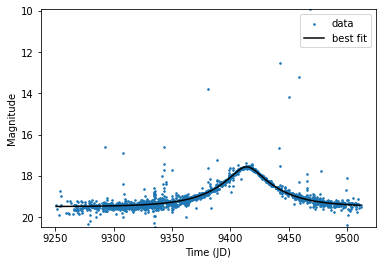

In [8]:
# plot data against model with initial linear and log guesses

# data:
plt.scatter(x, y, marker='.', label='data', s=10,) #yerr=df.mag_err)
#plt.errorbar(df.HJD, df.mag, yerr=df.mag_err, fmt=".")
plt.xlabel('Time (JD)')
plt.ylim([max(y),min(y)])
plt.ylabel('Magnitude')

# models:
#plt.plot(x,m(x,*lininit), label='linear model',color='r')
#plt.plot(x,logm(x,*loginit), label='log model')
plt.plot(x,logm(x-9400.,*popt), label='best fit',color='k')

plt.legend()
plt.show()

In [9]:
nwalkers = 50
ndim = len(popt)
# number of steps to walk and burn are initialized at top

pos = [popt + 1.0e-3 * np.random.randn(ndim) for i in range(nwalkers)]
print(popt)
sampler = emcee.EnsembleSampler(nwalkers,ndim,log_probability,args=(x-9400.,y,yerr))
sampler.run_mcmc(pos,steps,progress=True);
samples = sampler.get_chain(discard=burn, thin=20, flat=True).reshape((-1,ndim))

[13.98159863  1.62259678 -0.54840317 19.49233557  0.27218406]


100%|██████████| 5000/5000 [04:30<00:00, 18.49it/s]


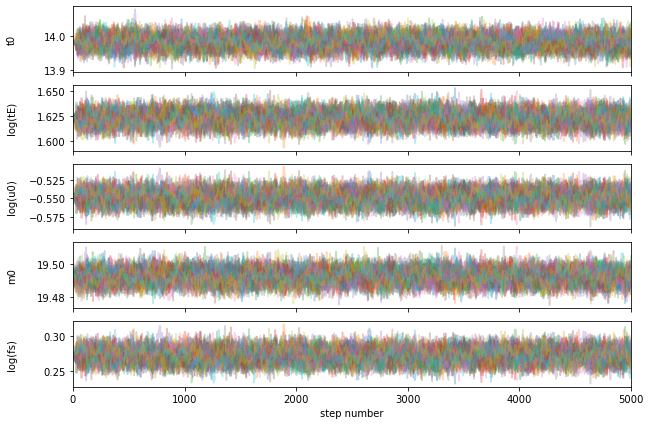

In [10]:
fig, axes = plt.subplots(len(popt), figsize=(10, 7), sharex=True)
samples_plot = sampler.get_chain()
labels = ["t0","log(tE)","log(u0)","m0","log(fs)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_plot[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples_plot))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()
#print(popt)

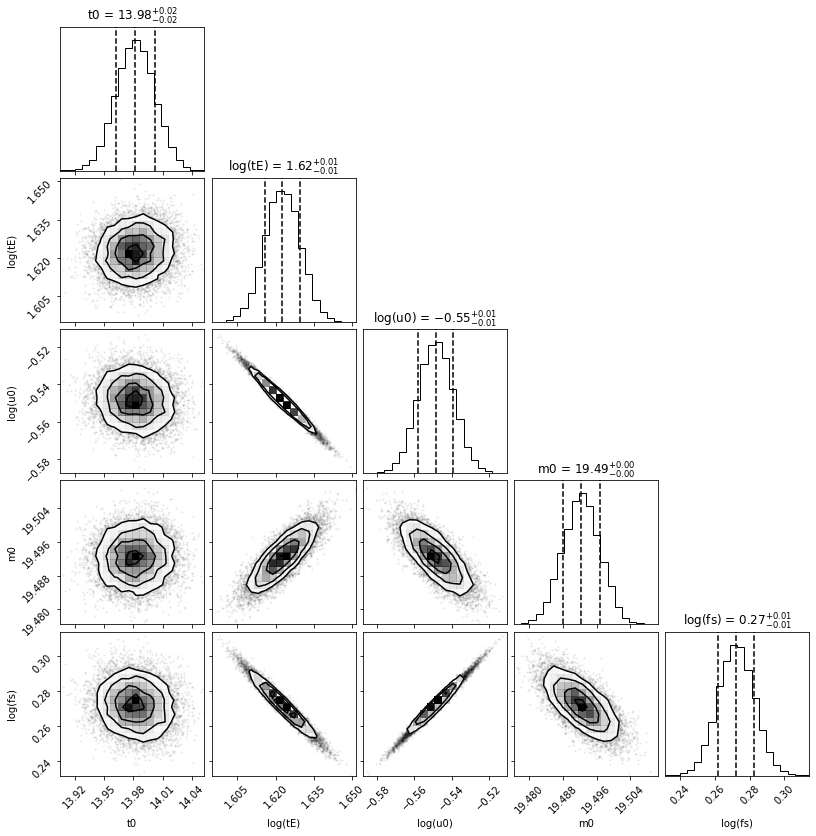

In [11]:
# creating corner plot of MCMC estimates with percentile labels

figure = corner.corner(
    samples,
    labels=["t0","log(tE)","log(u0)","m0","log(fs)"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
);

## prediction:

In [12]:
jddates = pd.read_csv("alertdates.csv")
df_forpred = df[df.HJD<jddates.JD[num]-2450000.]

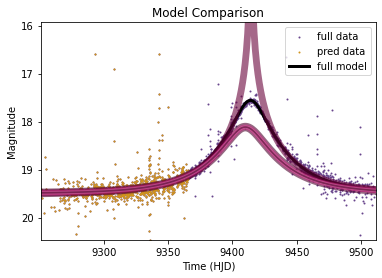

In [13]:
pred_t0 = [10,20,30,40,50,60]
pred_tE = [10,20,30,40,50,60]
pred_u0 = 0.1
pred_fs = 0.9

plt.xlabel('Time (HJD)')
plt.xlim(min(x),max(x))
plt.ylabel('Magnitude')
plt.ylim([max(y),min(y)+6])
plt.title('Model Comparison')
plt.scatter(x, y, marker='.', label='full data', s=4, color = '#68458c')
plt.scatter(df_forpred.HJD, df_forpred.mag, marker='.', label='pred data', s=4, color = '#d1941b')
plt.plot(x,logm(x-9400.,*popt), label='full model',color='k', lw=3)

shades = ['#ebd5e1','#52062f','#d16fa5','#cc2782','#69033b', '#4f022d','#e6d1dc']#'#aab78d','#9cb269','#637a30','#3f5f2f','#865d89','#533238']

for i in np.arange(5,-1,-1):
    var = i
    pred_loginit = [pred_t0[i],np.log10(pred_tE[i]),np.log10(pred_u0),m0,np.log10(pred_fs)]
    pred_popt,pred_pcov = opt.curve_fit(logm,df_forpred.HJD-9400.,df_forpred.mag,p0=pred_loginit,sigma=df_forpred.mag_err, bounds=([10., 1., -4., 15., -3.], [60., 2., .5, 25., 0.]))
    #print(pred_popt)
    plt.plot(x,logm(x-9400.,*pred_popt), alpha=.6, lw=var*1.7, color=shades[i])#, lw=.8)#label='t0 = '+str(pred_t0[i])
    
plt.legend()
plt.show()
#print(pred_popt)

In [17]:
#log_probability(pred_popt, df_forpred.HJD-9400., df_forpred.mag, df_forpred.mag_err)
nwalkers = 100
ndim = len(pred_popt)
# number of steps to walk and burn are initialized at top

pos = [pred_popt + 1.0e-2 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers,ndim,log_probability,args=(df_forpred.HJD-9400.,df_forpred.mag,df_forpred.mag_err))
sampler.run_mcmc(pos,steps,progress=True);
samples = sampler.get_chain(discard=burn, thin=20, flat=True).reshape((-1,ndim))

100%|██████████| 5000/5000 [07:06<00:00, 11.73it/s]


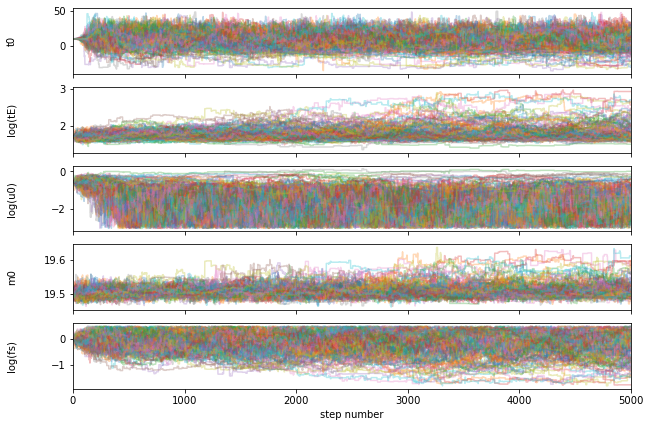

In [18]:
fig, axes = plt.subplots(len(pred_popt), figsize=(10, 7), sharex=True)
samples_plot = sampler.get_chain()
labels = ["t0","log(tE)","log(u0)","m0","log(fs)"]
for i in range(ndim):
    ax = axes[i]
    #for j in range(nwalkers):
    ax.plot(samples_plot[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples_plot))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()
#print(pred_popt)

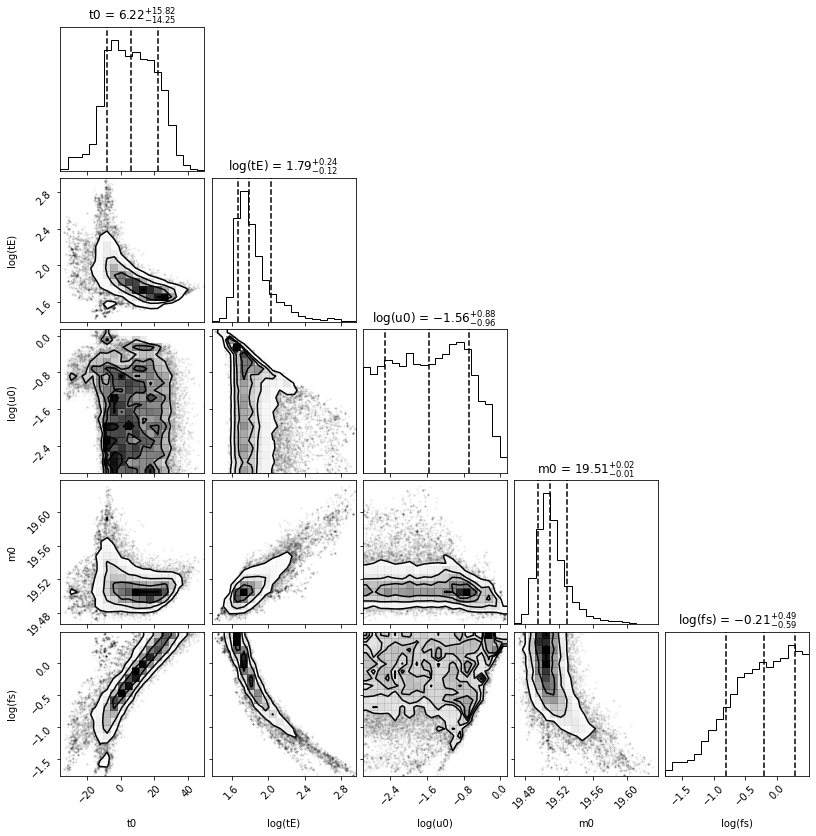

In [19]:
figure = corner.corner(
    samples,
    labels=["t0","log(tE)","log(u0)","m0","log(fs)"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
);